# PSF normalization

Let us assume that we have reduced an observation, for which we have determined the PSF by stacking the flux of point-like sources. The PSF we obtain will not be as high S/N as the instrumental PSF that has been determined by the instrument team. Moreover, it is likely to be fattened due to the some small pointing errors. We need to find out what fraction of a point-like flux the PSF we have determined represent. In order to do this, we use the growth curve of the theoretical PSF that has been determine by the instrument team, and compare it to the growth curve we determine from our PSF.

We will first look at a theoretical case, then go practical with an example drawn from the PACS observation of the the XMM-LSS.

## 1) Theoretical example. 

Let us suppose we have a perfect telescope, without any central obscuration and spider to support the secondary. Diffraction theory gives us the shape of a PSF in this case, an Airy function. Let's compute it, and assume the resolution is 10".


In [1]:
# import what we will need. 
%matplotlib inline
import numpy as np
from astropy.io import fits
from astropy.table import Table
from astropy.io import ascii as asciiread
from matplotlib import pyplot as plt
from scipy import interpolate 
from scipy import special
from scipy import signal
from scipy import fftpack

In [2]:
# Let us perform our computation with a 0.1" resolution on a 5' field of view
resol = 0.1
size = 300.
# wavelength
wavelength = 250e-6
# primary aperture = 3.6 m diameter
aperture = 3.6 / 2.

In [3]:
# Ensure we have an odd number of points 
nbpix = np.ceil(size/resol) // 2 * 2 + 1
xcen = int((nbpix - 1) / 2)
ycen = int((nbpix - 1) / 2)
x = y = (np.arange(nbpix) - xcen)*resol
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
r = np.sqrt(xv**2+yv**2)
# avoid division by 0 problems in the center
r[xcen,ycen] = 1e-6
# coordinates in fourier
q = 2 * np.pi / wavelength * aperture * np.sin(r/3600.*np.pi/180.)

In [4]:
psf = (2*special.jn(1, q)/q)**2

In [5]:
# put back the correct value at center
psf[xcen, ycen] = 1.
# and normalize the PSF
psf = psf/(np.sum(psf)*resol**2)

$\int\int$ psf dx dy = 1.0000000000000018


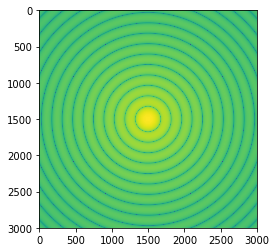

In [6]:
plt.imshow(np.log10(psf))
print(r'$\int\int$ psf dx dy = {}'.format(np.sum(psf)*resol**2))

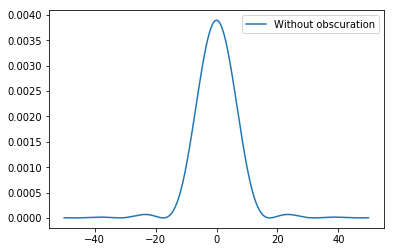

In [7]:
plt.plot(y[ycen-500:ycen+500], psf[ycen-500:ycen+500, xcen], label='Without obscuration')
plt.legend()

Let us now suppose that we observe a point source, and our image reconstruction has a ...This will shows a a blurring of the image, with a gaussian of 10" FWHM. Let's generate this blurring

In [8]:
fwhm = 10.
sigma = fwhm / 2. / np.sqrt(2. * np.log(fwhm))
sigmasq = sigma**2
kernel_blur = 1./ 2./ np.pi / sigmasq * np.exp(-(r**2/2./sigmasq))

In [9]:
# Check our kernel is properly normalized
np.sum(kernel_blur*resol**2)

0.99999999999999956

In [10]:
# apply the blur
psfblur = signal.convolve(psf, kernel_blur, mode='same')*resol**2

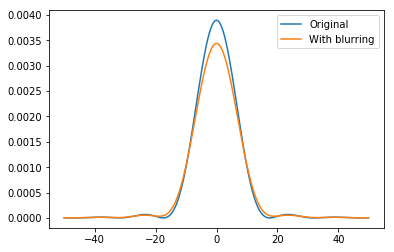

In [11]:
plt.plot(y[ycen-500:ycen+500], psf[ycen-500:ycen+500, xcen], label='Original')
plt.plot(y[ycen-500:ycen+500], psfblur[ycen-500:ycen+500, xcen], label='With blurring')
plt.legend()

We see the effect of blurring, the, observed PSF is wider, and we have lost some flux in the central core. Suppose now that we observed this psf with sources of unknown fluxes, so that we re unsure of its scaling, and that a background remain in our observation

In [12]:
psfobs = psfblur * 2. + 1e-4

The question is now how to recover the PSF that serve for our observation. For this, we will use the PSFs curve of growth. 

In [13]:
radii = np.arange(0, np.max(r), resol)
growth_psf = np.zeros(radii.shape)
growth_psfobs = np.zeros(radii.shape)
nbpix_psfobs = np.zeros(radii.shape)
for i, radius in enumerate(radii):
    if ((i % 100) == 0):
        print(radius, np.max(radii))
    if i == 0:
        idj, idi = np.where(r <= radius)
        growth_psf[i] = np.sum(psf[idj, idi])*resol**2
        growth_psfobs[i] = np.sum(psfobs[idj, idi])*resol**2
        nbpix_psfobs[i] =len(idi)
    else:
        idj, idi = np.where((r > radii[i-1]) & (r <= radius))
        growth_psf[i] = growth_psf[i-1]+np.sum(psf[idj, idi])*resol**2
        growth_psfobs[i] = growth_psfobs[i-1]+np.sum(psfobs[idj, idi])*resol**2
        nbpix_psfobs[i] = nbpix_psfobs[i-1]+len(idi)

0.0 212.1
10.0 212.1
20.0 212.1
30.0 212.1
40.0 212.1
50.0 212.1
60.0 212.1
70.0 212.1
80.0 212.1
90.0 212.1
100.0 212.1
110.0 212.1
120.0 212.1
130.0 212.1
140.0 212.1
150.0 212.1
160.0 212.1
170.0 212.1
180.0 212.1
190.0 212.1
200.0 212.1
210.0 212.1


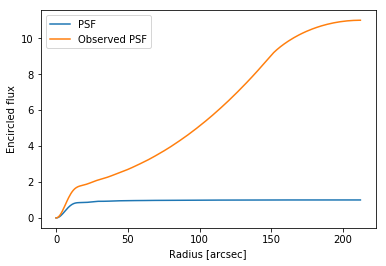

In [14]:
plt.plot(radii, growth_psf, label='PSF')
plt.plot(radii, growth_psfobs, label='Observed PSF')
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

This strongly rising shape of the observed PSF is a sure sign of an non zero background. Let's determine it. 

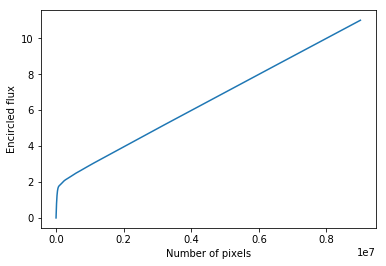

In [15]:
plt.plot(nbpix_psfobs, growth_psfobs)
plt.xlabel('Number of pixels')
plt.ylabel('Encircled flux')

When plotted as a function of the intergated area, there is a clear linear relation, that we will fit:

In [16]:
idx, = np.where(radii > 50)
p = np.polyfit(nbpix_psfobs[idx], growth_psfobs[idx], 1)
bkg = p[0]/resol**2

In [17]:
# Correct PSF and curve of growth
psfcor = psfobs-bkg
growth_psfcor = growth_psfobs - bkg*nbpix_psfobs*resol**2

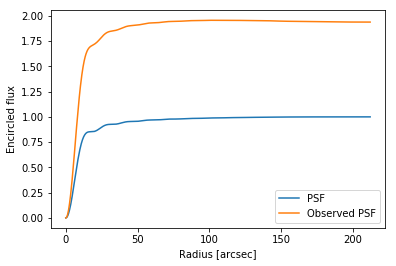

In [18]:
plt.plot(radii, growth_psf, label='PSF')
plt.plot(radii, growth_psfcor, label='Observed PSF')
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

<a id='direct_ratio'></a> Let's have a look at the ratio of the two:

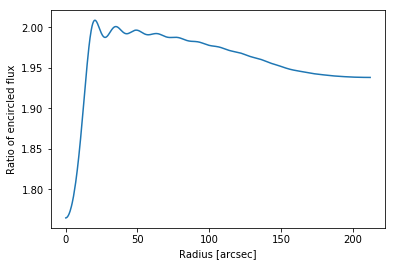

In [19]:
plt.plot(radii[1:], growth_psfcor[1:]/growth_psf[1:])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Ratio of encircled flux')


Due to the different resolution, the ratio is not constant. Let's note the calibration $C(r)$. Let us assume that our observed PSF encirled energy is of the form:

$E(r) = \alpha C(r \times \beta)$

Where $\beta$ is the fattening of the PSF. If we differentiate as a function of $r$:

$E'(r) = \alpha \beta C'(r \times \beta)$



In [20]:
# compute the derivatives
deriv_growth_psf = (growth_psf[2:]-growth_psf[0:-2])/(radii[2:]-radii[0:-2])
deriv_growth_psfcor  = (growth_psfcor[2:]-growth_psfcor[0:-2])/(radii[2:]-radii[0:-2])

(0, 60)

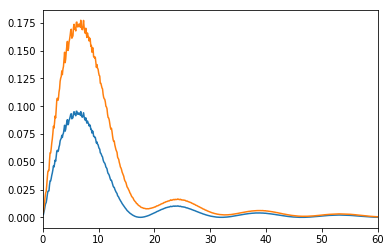

In [21]:
plt.plot(radii[1:-1], deriv_growth_psf)
plt.plot(radii[1:-1], deriv_growth_psfcor)
plt.xlim([0,60])

Compared with the growth curve plot, the derivative show clear maxima and minima that are out of phase. Findind the positions of the these will tell us if our assumption of homothetical variation is correct.

[  0.           6.18161082  17.48546882  23.79928199  32.07353102
  38.40607579  46.76238796] [  0.           6.52203326  18.7589197   24.07489413  32.78748297
  38.5386345   47.21468159]


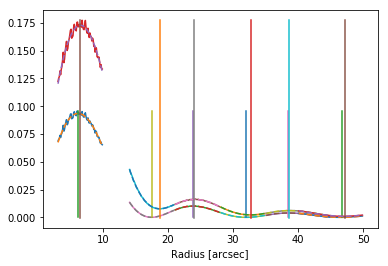

In [22]:
# Find the local minima and maxima of the two curves.
# To find a local extremum, we will fit the portion of curve with a degree 3 polynomial, 
# extract the roots of its derivative and only retain the one that are between the bounds.
# This is what the following function does.
def local_max(xvalues, yvalues, lower_bound, upper_bound, check_plot=False):
    idx,=np.where((xvalues > lower_bound) & (xvalues < upper_bound))
    p = np.polyfit(xvalues[idx], yvalues[idx], 3)
    delta = (2.*p[1])**2 - 4.*3.*p[0]*p[2]
    r1 = (-2*p[1]+np.sqrt(delta))/(2*3*p[0])
    r2 = (-2*p[1]-np.sqrt(delta))/(2*3*p[0])
    result = r1 if ((r1 > lower_bound) and (r1 < upper_bound)) else r2
    if check_plot:
        plt.plot(xvalues[idx], yvalues[idx])
        plt.plot(xvalues[idx], p[0]*xvalues[idx]**3+p[1]*xvalues[idx]**2+
                 p[2]*xvalues[idx]+p[3], '--')
        plt.plot(np.array([result, result]), np.array([np.min(yvalues), np.max(yvalues)]), '-')
    return result
    
    
max_dpsf_1 = local_max(radii[1:-1], deriv_growth_psf, 3, 10, check_plot=True)
max_dpsfcor_1 = local_max(radii[1:-1], deriv_growth_psfcor, 3, 10, check_plot=True)

max_dpsf_2 = local_max(radii[1:-1], deriv_growth_psf, 14, 21, check_plot=True)
max_dpsfcor_2 = local_max(radii[1:-1], deriv_growth_psfcor, 14, 21, check_plot=True)

max_dpsf_3 = local_max(radii[1:-1], deriv_growth_psf, 21, 28, check_plot=True)
max_dpsfcor_3 = local_max(radii[1:-1], deriv_growth_psfcor, 21, 28, check_plot=True)

max_dpsf_4 = local_max(radii[1:-1], deriv_growth_psf, 28, 35, check_plot=True)
max_dpsfcor_4 = local_max(radii[1:-1], deriv_growth_psfcor, 28, 35, check_plot=True)

max_dpsf_5 = local_max(radii[1:-1], deriv_growth_psf, 35, 45, check_plot=True)
max_dpsfcor_5 = local_max(radii[1:-1], deriv_growth_psfcor, 35, 45, check_plot=True)

max_dpsf_6 = local_max(radii[1:-1], deriv_growth_psf, 40, 50, check_plot=True)
max_dpsfcor_6 = local_max(radii[1:-1], deriv_growth_psfcor, 40, 50, check_plot=True)

plt.xlabel('Radius [arcsec]')

# Lets pack all of them, adding the r=0 point. 
max_dpsf = np.array([0, max_dpsf_1, max_dpsf_2, max_dpsf_3, max_dpsf_4, max_dpsf_5, max_dpsf_6])
max_dpsfcor = np.array([0, max_dpsfcor_1, max_dpsfcor_2, max_dpsfcor_3, max_dpsfcor_4, 
                        max_dpsfcor_5, max_dpsfcor_6])

print(max_dpsf,max_dpsfcor)

From the plot, we can deduce that our homothetical assumption is not perfect: the spacing increases for the first three (don't forget the point at 0, 0, not shown), is very small for the 4th and 6th, and gets narrower for the 5th and 7th...
Let's plot the situation

[ 1.07402112 -0.04599678]
1.05507018262
1.07282909576


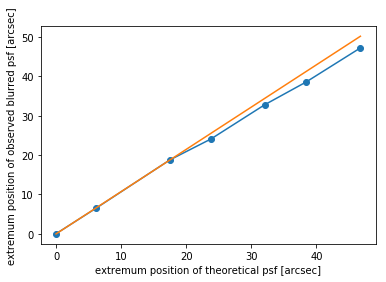

In [23]:
plt.plot(max_dpsf, max_dpsfcor, 'o-')
p = np.polyfit(max_dpsf[0:3], max_dpsfcor[0:3], 1)
plt.plot(max_dpsf, p[0]*max_dpsf+p[1])
plt.xlabel('extremum position of theoretical psf [arcsec]')
plt.ylabel('extremum position of observed blurred psf [arcsec]')


print(p)
print((max_dpsfcor[1]-max_dpsfcor[0])/(max_dpsf[1]-max_dpsf[0]))
print((max_dpsfcor[2]-max_dpsfcor[0])/(max_dpsf[2]-max_dpsf[0]))



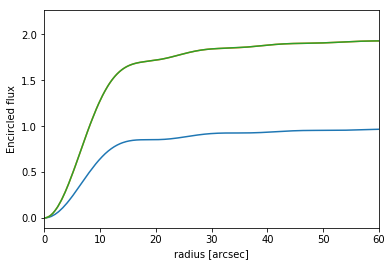

In [24]:
# Lets use the data before 20", corresponding to the central core
beta = (max_dpsfcor[2]-max_dpsfcor[0])/(max_dpsf[2]-max_dpsf[0])

# lets interpolate at the scaled radius
tckpsfcor = interpolate.splrep(radii, growth_psfcor, s=0)
interp_growth_psfcor = interpolate.splev(radii*beta, tckpsfcor, der=0)

# check interpolation
plt.plot(radii*beta, growth_psf)
plt.plot(radii, growth_psfcor)
plt.plot(radii*beta, interp_growth_psfcor)
plt.xlim([0,60])
plt.xlabel('radius [arcsec]')
plt.ylabel('Encircled flux')



Let us check the ratio, using the psf with a corrected radius

alpha = 2.005


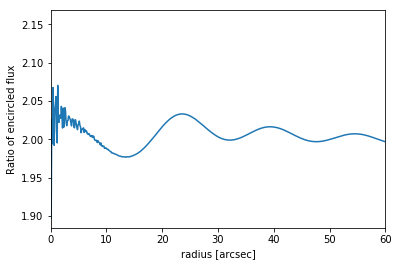

In [25]:
plt.plot(radii[1:]*beta, interp_growth_psfcor[1:]/growth_psf[1:])
plt.xlabel('radius [arcsec]')
plt.ylabel('Ratio of encircled flux')
plt.xlim([0,60])
idx, = np.where(((radii*p[0]) > 0) & ((radii*p[0]) < 60))
scale_factor = np.median(interp_growth_psfcor[idx]/growth_psf[idx])
print("alpha = {:.3f}".format(scale_factor))

We now have a much better looking ratio [compared with the cell where we computed the direct ratio](#the_ratio), and we have a decent determination of the psf scaling. The normalized PSF to use for our observations is then:

In [26]:
psf_obs_norm = psfcor / scale_factor

In [27]:
print('\int \int psf_obs_norm dx dy = {}'.format(np.sum(psf_obs_norm)*resol**2))

\int \int psf_obs_norm dx dy = 0.9664739715532878


Indeed, let's look at the encircled energy in the core of our psf:
In this example, we have used the derivative of the scale factor

In [28]:
idj, idi = np.where(r<max_dpsfcor_2)
print('central core for observation: {}'.format(np.sum(psf_obs_norm[idj, idi])*resol**2))
idj, idi = np.where(r<max_dpsf_2)
print('central core for theoretical: {}'.format(np.sum(psf[idj, idi])*resol**2))




central core for observation: 0.8526738059811085
central core for theoretical: 0.8526789463354869


The two agree extremely well. 

Unfortunately, with real data, it is not always possible as we will see to use the derivative of the curve of growth to derive the factor beta of PSF fattening. For real observation, one can use a brute force approach to try all the reasonable couples alpha, beta and try to match the theoretical psf to the observed one. This is how we will proceed next on real data.

## 2) Real data: MIPS observations

We will look at a real stack of point sources in the MIPS ELAIS-N1 observations, and try to find its normalization factor. 

Let's load the stacked PSF:

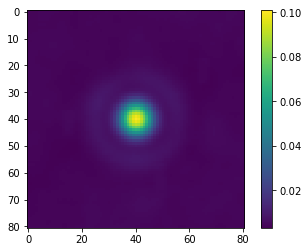

In [2]:
stackhd = fits.open('../data/CDFS-SWIRE/psf_hires.fits')
psf = stackhd[1].data
hd = stackhd[1].header
cpix=np.int((hd['NAXIS1']+1)/2.0)
rad=40
plt.imshow(psf[cpix-rad-1:cpix+rad,cpix-rad-1:cpix+rad])
plt.colorbar()

In [22]:
resol= 0.5

## Read in MIPS 24 $\mathrm{\mu m}$ Instrumental PSF
We take the instrumental PSF from [Gonzalo J.Aniano's webpage](http://www.astro.princeton.edu/~ganiano/Kernels/Ker_2017/PSF_FITS_Files/)

In [4]:
insthd = fits.open('../../dmu26/data/ELAIS_N1/MIPS/PSF_Original_MIPS_24.fits.gz')
psf_inst_full = insthd[0].data
hdinst = insthd[0].header


In [5]:
hdinst


SIMPLE  =                    T /image conforms to FITS standard                 
BITPIX  =                  -32 /bits per data value                             
NAXIS   =                    2 /number of axes                                  
NAXIS1  =                 4001 /                                                
NAXIS2  =                 4001 /                                                
EXTEND  =                    T /file may contain extensions                     
INSTRUME= '    MIPS_24_micron' / Simulated instrument                           
FOCUS   =              -0.1939 / RMS focus in microns                           
X_COMA  =               0.0946 / RMS X-coma in microns                          
Y_COMA  =              -0.0066 / RMS Y-coma in microns                          
X_ASTIG =               0.5911 / RMS 0 degree astigmatism in microns            
Y_ASTIG =              -0.1078 / RMS 45 degree astigmatism in microns           
SPHERICL=              -0.27

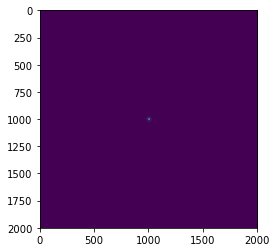

In [6]:
rad=1000
cpix=np.int((hdinst['NAXIS1']+1)/2.0)

plt.imshow(psf_inst_full[cpix-rad-1:cpix+rad,cpix-rad-1:cpix+rad])
#psf_inst=psf_inst_full[hdinst['CRPIX1']-rad-1:hdinst['CRPIX1']+rad,hdinst['CRPIX2']-rad-1:hdinst['CRPIX2']+rad]
psf_inst=psf_inst_full[cpix-rad-1:cpix+rad,cpix-rad-1:cpix+rad]

### Normalise instrumental PSF such that integral=1

In [7]:
psf_inst=psf_inst/(np.sum(psf_inst))

Now let's build the growthcurve for our PSFs.

In [8]:
# find the brightest pixel, it will be our center.
jmax, imax = np.unravel_index(np.argmax(psf), psf.shape)
jmax_inst, imax_inst = np.unravel_index(np.argmax(psf_inst), psf_inst.shape)


In [9]:
# build the array of coordinates
x = np.arange(hd['NAXIS1'])
y = np.arange(hd['NAXIS2'])
xv, yv = np.meshgrid(x, y, sparse=False, indexing='xy')
xp = (xv-imax)*np.abs(hd['CDELT1'])*3600.
yp = (yv-jmax)*np.abs(hd['CDELT2'])*3600.
r = np.sqrt(xp**2 + yp**2)

x_inst = np.arange(1+rad*2)
y_inst = np.arange(1+rad*2)
xv_inst, yv_inst = np.meshgrid(x_inst, y_inst, sparse=False, indexing='xy')
xp_inst = (xv_inst-imax_inst)*np.abs(hdinst['CD1_1']*3600.0)
yp_inst = (yv_inst-jmax_inst)*np.abs(hdinst['CD1_1']*3600.0)
r_inst = np.sqrt(xp_inst**2 + yp_inst**2)

In [10]:
# build the growth curve
radii = np.unique(r)
encircled_flux = np.zeros(radii.shape)
nbpix = np.zeros(radii.shape)
for i, radius in enumerate(radii):
    idj, idi = np.where(r <= radius)
    nbpix[i] =len(idi)
    #multiply by ((np.abs(hd['CDELT1'])*3600.)**2)/4.25E10 as map is in units of MJy/sr
    encircled_flux[i] = np.sum(psf[idj, idi])*((np.abs(hd['CDELT1'])*3600.)**2)/4.25E10

In [11]:

radii_inst = np.unique(r_inst)
encircled_flux_inst = np.zeros(radii_inst.shape)
nbpix_inst = np.zeros(radii_inst.shape)
for i, radius in enumerate(radii_inst):
    if i % 1000 == 0:
        print(i,len(radii_inst))
    idj, idi = np.where(r_inst <= radius)
    nbpix_inst[i] =len(idi)
    encircled_flux_inst[i] = np.sum(psf_inst[idj, idi])
    

0 350777
1000 350777
2000 350777
3000 350777
4000 350777
5000 350777
6000 350777
7000 350777
8000 350777
9000 350777
10000 350777
11000 350777
12000 350777
13000 350777
14000 350777
15000 350777
16000 350777
17000 350777
18000 350777
19000 350777
20000 350777
21000 350777
22000 350777
23000 350777
24000 350777
25000 350777
26000 350777
27000 350777
28000 350777
29000 350777
30000 350777
31000 350777
32000 350777
33000 350777
34000 350777
35000 350777
36000 350777
37000 350777
38000 350777
39000 350777
40000 350777
41000 350777
42000 350777
43000 350777
44000 350777
45000 350777
46000 350777
47000 350777
48000 350777
49000 350777
50000 350777
51000 350777
52000 350777
53000 350777
54000 350777
55000 350777
56000 350777
57000 350777
58000 350777
59000 350777
60000 350777
61000 350777
62000 350777
63000 350777
64000 350777
65000 350777
66000 350777
67000 350777
68000 350777
69000 350777
70000 350777
71000 350777
72000 350777
73000 350777
74000 350777
75000 350777
76000 350777
77000 350777

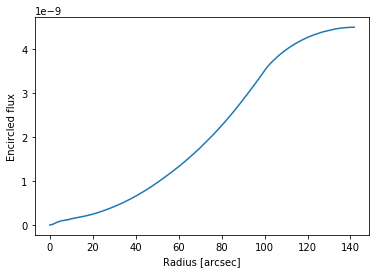

In [12]:
plt.plot(radii, encircled_flux)

plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')

Looking at the shape of the encircled flux, it looks like the background level of our PSF is not zero. Let's check

In [13]:
# This is clearly. 
print(np.median(psf[0:5,:]))

0.0044208


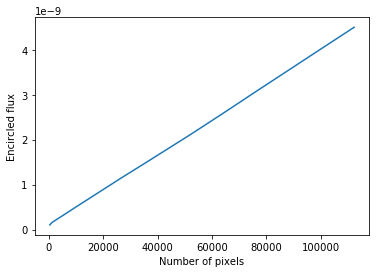

In [14]:
plt.plot(nbpix[50:], encircled_flux[50:])
plt.xlabel('Number of pixels')
plt.ylabel('Encircled flux')

In [23]:
# Lets do a linear fit to the outer part of the curve to determine the backgound
p = np.polyfit(nbpix[10000:], encircled_flux[10000:], 1)
bkg = p[0]/resol**2

In [24]:
bkg

1.5684341177329885e-13

In [25]:
# Lets correct the psf and encircled flux
psf = psf - bkg
encircled_flux = encircled_flux - bkg * nbpix*resol**2

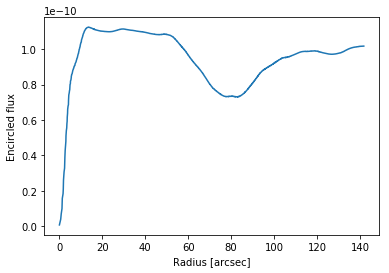

In [26]:
plt.plot(radii, encircled_flux)
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')

Our PSF does now behaves correctly.

Now let us compare our growth curve with the encircled energy curve from the instrumental PSF.  

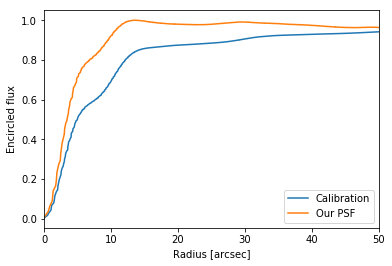

In [27]:
plt.plot(radii_inst, encircled_flux_inst, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 50])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

We will work below 30" where our PSF is well behaved

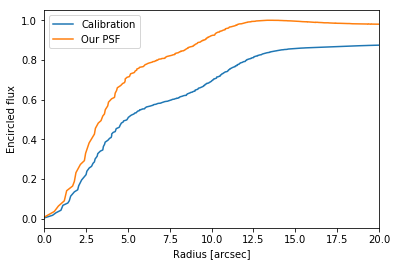

In [28]:
plt.plot(radii_inst, encircled_flux_inst, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 20])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

We see that while the calibration curve still rises beyond 30", our PSF has reached a plateau. Let's note the calibration $C(r)$. Our PSF encirled energy is of the form:

$E(r) = \alpha C(r \times \beta)$

Where $\beta$ is the fattening of the PSF.

We could take the derivative, but this too noisy. Instead we do a brute force approach

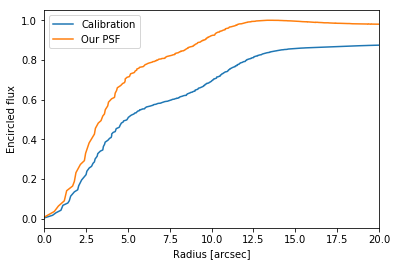

In [29]:
plt.plot(radii_inst, encircled_flux_inst, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux), label='Our PSF')
plt.xlim([0, 20])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

In [30]:
rfactor = np.arange(1.,2., 1e-3)
ffactor = np.arange(1.,2., 1e-3)
# work with the data points between 3 and 25"
idx, = np.where((radii > 2) & (radii < 10))
xv = radii[idx]
yv = encircled_flux[idx]/np.max(encircled_flux)
resid = np.zeros((len(rfactor), len(ffactor)))
for i, rf in enumerate(rfactor):
    tck = interpolate.splrep(radii_inst*rf,encircled_flux_inst , s=1)#changed s=0 to 1 as I was getting NaNs
    yfit = interpolate.splev(xv, tck, der=0)
    print(i, rf,np.isnan(yfit).sum())

    for j, ff in enumerate(ffactor):
        resid[i, j] = np.sum((yv-yfit*ff)**2)


0 1.0 0
1 1.001 0
2 1.002 0
3 1.003 0
4 1.004 0
5 1.005 0
6 1.006 0
7 1.007 0
8 1.008 0
9 1.009 0
10 1.01 0
11 1.011 0
12 1.012 0
13 1.013 0
14 1.014 0
15 1.015 0
16 1.016 0
17 1.017 0
18 1.018 0
19 1.019 0
20 1.02 0
21 1.021 0
22 1.022 0
23 1.023 0
24 1.024 0
25 1.025 0
26 1.026 0
27 1.027 0
28 1.028 0
29 1.029 0
30 1.03 0
31 1.031 0
32 1.032 0
33 1.033 0
34 1.034 0
35 1.035 0
36 1.036 0
37 1.037 0
38 1.038 0
39 1.039 0
40 1.04 0
41 1.041 0
42 1.042 0
43 1.043 0
44 1.044 0
45 1.045 0
46 1.046 0
47 1.047 0
48 1.048 0
49 1.049 0
50 1.05 0
51 1.051 0
52 1.052 0
53 1.053 0
54 1.054 0
55 1.055 0
56 1.056 0
57 1.057 0
58 1.058 0
59 1.059 0
60 1.06 0
61 1.061 0
62 1.062 0
63 1.063 0
64 1.064 0
65 1.065 0
66 1.066 0
67 1.067 0
68 1.068 0
69 1.069 0
70 1.07 0
71 1.071 0
72 1.072 0
73 1.073 0
74 1.074 0
75 1.075 0
76 1.076 0
77 1.077 0
78 1.078 0
79 1.079 0
80 1.08 0
81 1.081 0
82 1.082 0
83 1.083 0
84 1.084 0
85 1.085 0
86 1.086 0
87 1.087 0
88 1.088 0
89 1.089 0
90 1.09 0
91 1.091 0
92 1.092 

699 1.699 0
700 1.7 0
701 1.701 0
702 1.702 0
703 1.703 0
704 1.704 0
705 1.705 0
706 1.706 0
707 1.707 0
708 1.708 0
709 1.709 0
710 1.71 0
711 1.711 0
712 1.712 0
713 1.713 0
714 1.714 0
715 1.715 0
716 1.716 0
717 1.717 0
718 1.718 0
719 1.719 0
720 1.72 0
721 1.721 0
722 1.722 0
723 1.723 0
724 1.724 0
725 1.725 0
726 1.726 0
727 1.727 0
728 1.728 0
729 1.729 0
730 1.73 0
731 1.731 0
732 1.732 0
733 1.733 0
734 1.734 0
735 1.735 0
736 1.736 0
737 1.737 0
738 1.738 0
739 1.739 0
740 1.74 0
741 1.741 0
742 1.742 0
743 1.743 0
744 1.744 0
745 1.745 0
746 1.746 0
747 1.747 0
748 1.748 0
749 1.749 0
750 1.75 0
751 1.751 0
752 1.752 0
753 1.753 0
754 1.754 0
755 1.755 0
756 1.756 0
757 1.757 0
758 1.758 0
759 1.759 0
760 1.76 0
761 1.761 0
762 1.762 0
763 1.763 0
764 1.764 0
765 1.765 0
766 1.766 0
767 1.767 0
768 1.768 0
769 1.769 0
770 1.77 0
771 1.771 0
772 1.772 0
773 1.773 0
774 1.774 0
775 1.775 0
776 1.776 0
777 1.777 0
778 1.778 0
779 1.779 0
780 1.78 0
781 1.781 0
782 1.782 0
78

This shows a minimum, with some degeneracy. 

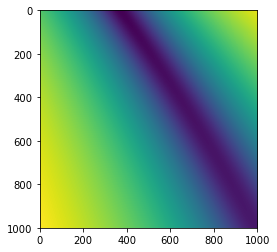

In [31]:
plt.imshow(np.log(resid))

In [32]:
imin = np.argmin(resid)
rmin, fmin = np.unravel_index(imin, resid.shape)
print("rf = {:.3f}, ff = {:.3f}, residual = {:.3f}".format(rfactor[rmin], ffactor[fmin], resid[rmin, fmin]))

rf = 1.000, ff = 1.368, residual = 0.190


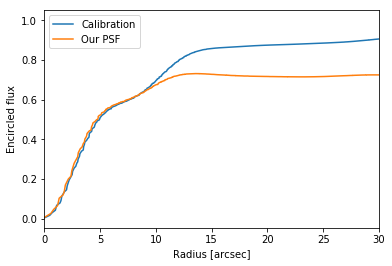

In [33]:
plt.plot(radii_inst*rfactor[rmin],encircled_flux_inst, label='Calibration')
plt.plot(radii, encircled_flux/np.max(encircled_flux)/ffactor[fmin], label='Our PSF')
plt.xlim([0, 30])
plt.xlabel('Radius [arcsec]')
plt.ylabel('Encircled flux')
plt.legend()

In [34]:
# The two curve overlap
rad=20
psfok = (psf/np.max(encircled_flux)/ffactor[fmin])
cpix=np.int((hd['NAXIS1']+1)/2.0)
np.sum(psfok[cpix-rad-1:cpix+rad,cpix-rad-1:cpix+rad])*((np.abs(hd['CDELT1'])*3600.)**2)/4.25E10

1.1538133441194973

psfok is the PSF that a source of flux 1 Jy has in our data, and is to be used for source extraction.
## As units of map in MJy/sr, divide by 1E6

In [35]:
psfok=psfok/1.0E6

## Validation
To check PSF is reasonable, lets look at a 24 micron source, e.g. SDSS J161432.52+544855.8. We can see from [NED](http://ned.ipac.caltech.edu/cgi-bin/datasearch?search_type=Photo_id&objid=8121372&objname=SDSS%20J161432.52%2B544855.8&img_stamp=YES&hconst=73.0&omegam=0.27&omegav=0.73&corr_z=1&of=table) that it has a flux of 1.67E-03 Jy. Maximum value in our normalised PSF gives a peak below. Since PSF is double resolution of map, it could also be off centre. Map has value of 0.96 MJy/sr but does appear to be off centre. 

In [41]:
print("Max PSF = {:.3f} MJy/sr, off pixel Max PSF = {:.3f} MJy/sr".format(psfok[cpix-1,cpix-1]*8.6088E-4,psfok[cpix-2,cpix-2]*8.6088E-4))

Max PSF = 0.565 MJy/sr, off pixel Max PSF = 0.538 MJy/sr


/Users/pdh21/anaconda3/envs/new/lib/python3.6/site-packages/aplpy/normalize.py:115: RuntimeWarning: invalid value encountered in less
  negative = result < 0.


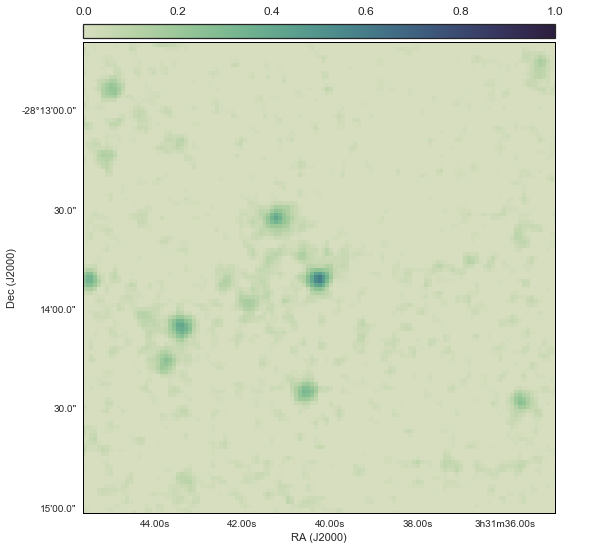

In [45]:
import aplpy
import seaborn as sns
sns.set_style("white")
cmap=sns.cubehelix_palette(8, start=.5, rot=-.75,as_cmap=True)
fig=aplpy.FITSFigure('../../dmu26/data/CDFS-SWIRE/wp4_cdfs-swire_mips24_map_v1.0.fits.gz')
fig.recenter(52.9212,-28.2276, radius=0.002)
fig.show_colorscale(vmin=0.0,vmax=1.0,cmap=cmap)
fig.add_colorbar()
fig.colorbar.set_location('top')

In summary, the PSF is within 10% of this source, and given noise and shape of source will add additional uncertianty this seems reasonable.

# Create PSF fits file

In [46]:
stackhd[1].data=psfok
stackhd.writeto('dmu17_MIPS_PSF_CDFS-SWIRE_20170818.fits')